In [430]:
import pandas as pd
import ast
import numpy as np

In [431]:
def convert_str_to_list(coord_str):
    return ast.literal_eval(coord_str)

train_barlines = pd.read_csv('deepscores_train_barlines.csv')

train_barlines['a_bbox'] = train_barlines['a_bbox'].apply(convert_str_to_list)
train_barlines['o_bbox'] = train_barlines['o_bbox'].apply(convert_str_to_list)

# Sort by 'filename' first, then by y-coordinate, then by x-coordinate
train_barlines = train_barlines.iloc[np.lexsort((train_barlines['o_bbox'].apply(lambda x: x[0]),
                                                 train_barlines['o_bbox'].apply(lambda x: x[1]),
                                                 train_barlines['filename']))]

# Getting the line number and measure numbers for barlines

In [432]:
# Function to detect if bboxes are on the same line
def on_same_line(bbox1, bbox2):
    # Extract the y-coordinates of the top left corner of the bounding boxes
    y1_top_left = bbox1[1]
    y2_top_left = bbox2[1]
    
    # Check if the y-coordinates are within a 1-2 pixel range
    return abs(y1_top_left - y2_top_left) <= 2

def check_and_assign_measure(group, current_index, measure_num):
    # Check for adjacent line measures and assign the same measure number
    for j in range(current_index + 1, len(group)):
        if group.iat[j, group.columns.get_loc('measure_number')] == -1:
            if abs(group.iat[current_index, group.columns.get_loc('x_coord')] - group.iat[j, group.columns.get_loc('x_coord')]) <= 2 and \
               abs(group.iat[current_index, group.columns.get_loc('line_number')] - group.iat[j, group.columns.get_loc('line_number')]) == 1:
                group.iat[j, group.columns.get_loc('measure_number')] = measure_num
                # Recursively check the next line
                check_and_assign_measure(group, j, measure_num)

# Function to numerically encode the bar lines based on their y-coordinates
def process_group(group, filename):
    
    # Sort by y-coordinate first to group by line, then by x-coordinate to maintain left-to-right order
    # Assuming 'o_bbox' is a list with the structure [x1, y1, x2, y2, x3, y3, x4, y4]
    # where (x1, y1) are the coordinates for the top-left corner of the bbox
    group = group.sort_values(by=['o_bbox']).reset_index(drop=True)
    
    # Split the 'o_bbox' column into separate x and y columns for sorting
    group['x_coord'] = group['o_bbox'].apply(lambda x: x[0])  # x1 coordinate
    group['y_coord'] = group['o_bbox'].apply(lambda x: x[1])  # y1 coordinate
    group = group.sort_values(by=['y_coord', 'x_coord']).reset_index(drop=True)

    # Initialize line number
    line_number = 0
    group['line_number'] = line_number  # Initialize line number column
    
    # Iterate through each bbox
    for i in range(1, len(group)):
        # If the y-coordinates change significantly, it's a new line
        if not on_same_line(group.iloc[i-1]['o_bbox'], group.iloc[i]['o_bbox']):
            line_number += 1
            # probably error
            if line_number == 100:
                print(f"Line number exceeded 100 for {filename}")
        # Assign the current line number
        group.iat[i, group.columns.get_loc('line_number')] = line_number

    # Normalize the y-coordinates within each line
    for line in group['line_number'].unique():
        mean_y = group[group['line_number'] == line]['y_coord'].mean()
        group.loc[group['line_number'] == line, 'y_coord'] = mean_y

    # Identify and remove redundant barlines
    max_x_per_line = group.groupby('line_number')['x_coord'].max()
    group = group[group.apply(lambda row: row['x_coord'] < max_x_per_line[row['line_number']], axis=1)]

    # Initialize measure numbers
    group['measure_number'] = -1  # Initialize with -1 to denote unassigned measures
    measure_number = 0

    group = group.sort_values(by=['y_coord', 'x_coord'], ascending=[True, False]).reset_index(drop=True)

    # Assign measure numbers by comparing each bbox to every other bbox
    for i in range(len(group)):
        if group.iat[i, group.columns.get_loc('measure_number')] == -1:
            group.iat[i, group.columns.get_loc('measure_number')] = measure_number
            check_and_assign_measure(group, i, measure_number)
            measure_number += 1  # Increment measure number after fully exploring all consecutive lines

        if measure_number == 200:
            print(f"Measure number exceeded 200 for {filename}")  # Error handling if too many measures


    # Drop the helper columns after processing
    group.drop(['x_coord', 'y_coord'], axis=1, inplace=True)
    
    return group


# Group by 'filename' and apply the process_group function with sorting

# # The rest of your code remains the same.
# image_path = 'lg-102414375-aug-beethoven--page-2.png'
# train_barlines = train_barlines[train_barlines["filename"]==image_path]

train_barlines = train_barlines.groupby('filename', group_keys=False).apply(lambda x: process_group(x, x.name), include_groups=True).reset_index(drop=True)

train_barlines = train_barlines.sort_values(by=['filename', 'line_number', 'measure_number'])

train_barlines.head(20)

/var/folders/g8/btdyhprd6l7_z7kmyr6qhzp80000gn/T/ipykernel_3206/4139608318.py:86: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_barlines = train_barlines.groupby('filename', group_keys=False).apply(lambda x: process_group(x, x.name), include_groups=True).reset_index(drop=True)


,filename,a_bbox,o_bbox,padded_a_bbox,padded_o_bbox,area,width,height,ann_id,label,duration,rel_position,duration_mask,rel_position_mask,line_number,measure_number
0,lg-101766503886095953-aug-beethoven--page-1.png,"[1387.0, 377.0, 1390.0, 443.0]","[1387.0, 377.0, 1390.0, 377.0, 1387.0, 443.0, ...","[1387.0, 377.0, 1390.0, 443.0]","[1387.0, 377.0, 1390.0, 377.0, 1387.0, 443.0, ...",198.0,-1,-1,-5157,156,-1,0,0,0,0,0
1,lg-101766503886095953-aug-beethoven--page-1.png,"[910.0, 377.0, 913.0, 443.0]","[910.0, 377.0, 913.0, 377.0, 910.0, 443.0, 913...","[910.0, 377.0, 913.0, 443.0]","[910.0, 377.0, 913.0, 377.0, 910.0, 443.0, 913...",198.0,-1,-1,-5158,156,-1,0,0,0,0,1
2,lg-101766503886095953-aug-beethoven--page-1.png,"[1387.0, 606.0, 1390.0, 671.0]","[1387.0, 606.0, 1390.0, 606.0, 1387.0, 671.0, ...","[1387.0, 606.0, 1390.0, 671.0]","[1387.0, 606.0, 1390.0, 606.0, 1387.0, 671.0, ...",195.0,-1,-1,-5153,156,-1,0,0,0,1,0
3,lg-101766503886095953-aug-beethoven--page-1.png,"[910.0, 606.0, 913.0, 671.0]","[910.0, 606.0, 913.0, 606.0, 910.0, 671.0, 913...","[910.0, 606.0, 913.0, 671.0]","[910.0, 606.0, 913.0, 606.0, 910.0, 671.0, 913...",195.0,-1,-1,-5154,156,-1,0,0,0,1,1
4,lg-101766503886095953-aug-beethoven--page-1.png,"[1387.0, 834.0, 1390.0, 899.0]","[1387.0, 834.0, 1390.0, 834.0, 1387.0, 899.0, ...","[1387.0, 834.0, 1390.0, 899.0]","[1387.0, 834.0, 1390.0, 834.0, 1387.0, 899.0, ...",195.0,-1,-1,-5150,156,-1,0,0,0,2,0
5,lg-101766503886095953-aug-beethoven--page-1.png,"[910.0, 833.0, 913.0, 900.0]","[910.0, 833.0, 913.0, 833.0, 910.0, 900.0, 913...","[910.0, 833.0, 913.0, 900.0]","[910.0, 833.0, 913.0, 833.0, 910.0, 900.0, 913...",201.0,-1,-1,-5152,156,-1,0,0,0,2,1
6,lg-101766503886095953-aug-beethoven--page-1.png,"[1387.0, 1027.0, 1390.0, 1092.0]","[1387.0, 1027.0, 1390.0, 1027.0, 1387.0, 1092....","[1387.0, 1027.0, 1390.0, 1092.0]","[1387.0, 1027.0, 1390.0, 1027.0, 1387.0, 1092....",195.0,-1,-1,-5147,156,-1,0,0,0,3,0
7,lg-101766503886095953-aug-beethoven--page-1.png,"[910.0, 1027.0, 913.0, 1092.0]","[910.0, 1027.0, 913.0, 1027.0, 910.0, 1092.0, ...","[910.0, 1027.0, 913.0, 1092.0]","[910.0, 1027.0, 913.0, 1027.0, 910.0, 1092.0, ...",195.0,-1,-1,-5148,156,-1,0,0,0,3,1
8,lg-101766503886095953-aug-beethoven--page-1.png,"[1465.0, 1754.0, 1468.0, 1819.0]","[1465.0, 1754.0, 1468.0, 1754.0, 1465.0, 1819....","[1465.0, 1754.0, 1468.0, 1819.0]","[1465.0, 1754.0, 1468.0, 1754.0, 1465.0, 1819....",195.0,-1,-1,-5143,156,-1,0,0,0,4,2
9,lg-101766503886095953-aug-beethoven--page-1.png,"[1064.0, 1754.0, 1067.0, 1820.0]","[1064.0, 1754.0, 1067.0, 1754.0, 1064.0, 1820....","[1064.0, 1754.0, 1067.0, 1820.0]","[1064.0, 1754.0, 1067.0, 1754.0, 1064.0, 1820....",198.0,-1,-1,-5146,156,-1,0,0,0,4,3


In [433]:
train_barlines = train_barlines.sort_values(by=['filename', 'line_number', 'measure_number'])

# Creating measures using barlines

In [434]:
def group_measures_by_line(group):
    # Sort the group by line number and measure number
    sorted_group = group.sort_values(by=['line_number', 'measure_number'])
    measure_memo = set()
    # Dictionary to hold the bounding boxes grouped by line and measure
    bbox_groups = {}
    special_measure_count = 1  # Counter for special measures

    # Iterate over each line
    for line_number in sorted_group['line_number'].unique():
        line_data = sorted_group[sorted_group['line_number'] == line_number].copy()

        # Check if there is only one row in this line
        if len(line_data) == 1:

            current_measure = line_data['measure_number'].values[0]

            if current_measure in measure_memo:
                continue
            else:
                measure_memo.add(current_measure)

            measure_key_initial = f"initial_special_measure_{special_measure_count}"
            
            measure_key_final = f"final_special_measure_{special_measure_count}"

            # Initialize measure key if not present
            if measure_key_initial not in bbox_groups:
                bbox_groups[measure_key_initial] = []

            # Initialize measure key if not present
            if measure_key_final not in bbox_groups:
                bbox_groups[measure_key_final] = []
            
            # Original bbox
            bbox_groups[measure_key_initial].append(line_data['o_bbox'].values[0].copy())

            # Original bbox
            bbox_groups[measure_key_final].append(line_data['o_bbox'].values[0].copy())


            # Append all bounding boxes for the same measure
            for coords in group[group['measure_number']==current_measure]['o_bbox'].values:
                bbox_groups[measure_key_initial].append(coords)
                bbox_groups[measure_key_final].append(coords)

            # Modified bbox with certain indices set to 0
            modified_bbox_initial = line_data['o_bbox'].values[0].copy()
            for index in [0]:
                modified_bbox_initial[index] = 0  # Set specified indices to 0
            bbox_groups[measure_key_initial].append(modified_bbox_initial)

            # Modified bbox with certain indices set to 1960
            modified_bbox_final = line_data['o_bbox'].values[0].copy()
            for index in [0]:
                modified_bbox_final[index] = 1960  # Set specified indices to 1960
            bbox_groups[measure_key_final].append(modified_bbox_final)

            special_measure_count += 1

        else:
            # Iterate through the measures in the line normally
            for i in range(len(line_data) - 1):  # -1 because we look ahead one measure
                current_measure = line_data.iloc[i]
                next_measure = line_data.iloc[i + 1]

                # Check if the next measure number is consecutive
                if current_measure['measure_number'] + 1 == next_measure['measure_number']:
                    # Create the key as 'measure_current_current+1'
                    key = f"measure_{current_measure['measure_number']}_{next_measure['measure_number']}"
                    
                    # If the key doesn't exist, create it and assign an empty list
                    if key not in bbox_groups:
                        bbox_groups[key] = []

                    # Append the current and next bounding boxes to the list under the key
                    bbox_groups[key].append(current_measure['o_bbox'])
                    bbox_groups[key].append(next_measure['o_bbox'])

    return bbox_groups

# Now, group by 'filename' and apply the grouping function
grouped_bbox_data = train_barlines.groupby("filename").apply(group_measures_by_line, include_groups=False)

# Now, group by 'filename' and apply the grouping function
grouped_bbox_df = pd.DataFrame(grouped_bbox_data).reset_index().rename(columns={'level_0': 'filename', 'level_1': 'data'})

grouped_bbox_df.head(20)

,filename,0
0,lg-101766503886095953-aug-beethoven--page-1.png,"{'measure_0_1': [[1387.0, 377.0, 1390.0, 377.0..."
1,lg-101766503886095953-aug-beethoven--page-4.png,"{'measure_0_1': [[1456.0, 128.0, 1459.0, 128.0..."
2,lg-101766503886095953-aug-gonville--page-1.png,"{'measure_0_1': [[1381.0, 377.0, 1384.0, 377.0..."
3,lg-101766503886095953-aug-gonville--page-4.png,"{'measure_0_1': [[1453.0, 128.0, 1457.0, 128.0..."
4,lg-102414375-aug-beethoven--page-2.png,"{'measure_0_1': [[1435.0, 128.0, 1438.0, 128.0..."
5,lg-102414375-aug-gutenberg1939--page-3.png,"{'measure_0_1': [[1560.0, 139.0, 1563.0, 139.0..."
6,lg-10247684-aug-beethoven--page-2.png,"{'initial_special_measure_1': [[1061.0, 146.0,..."
7,lg-10247684-aug-beethoven--page-3.png,"{'measure_0_1': [[1305.0, 173.0, 1308.0, 173.0..."
8,lg-10247684-aug-gonville--page-2.png,"{'initial_special_measure_1': [[1058.0, 146.0,..."
9,lg-10247684-aug-gonville--page-3.png,"{'measure_0_1': [[1301.0, 173.0, 1304.0, 173.0..."


In [435]:
# def group_measures_by_line(group):
#     # Sort the group by line number and measure number
#     sorted_group = group.sort_values(by=['line_number', 'measure_number'])

#     # Dictionary to hold the bounding boxes grouped by line and measure
#     bbox_groups = {}

#     # Iterate over each line
#     for line_number in sorted_group['line_number'].unique():
#         line_data = sorted_group[sorted_group['line_number'] == line_number]
        
#         # Iterate through the measures in the line
#         for i in range(len(line_data) - 1):  # -1 because we look ahead one measure
#             current_measure = line_data.iloc[i]
#             next_measure = line_data.iloc[i + 1]

#             # Check if the next measure number is consecutive
#             if current_measure['measure_number'] + 1 == next_measure['measure_number']:
#                 # Create the key as 'measure_current_current+1'
#                 key = f"measure_{current_measure['measure_number']}_{next_measure['measure_number']}"
                
#                 # If the key doesn't exist, create it and assign an empty list
#                 if key not in bbox_groups:
#                     bbox_groups[key] = []

#                 # Append the current and next bounding boxes to the list under the key
#                 bbox_groups[key].append(current_measure['o_bbox'])
#                 bbox_groups[key].append(next_measure['o_bbox'])

#     return bbox_groups


# # test_df = train_barlines.loc[train_barlines["filename"] == 'lg-101766503886095953-aug-beethoven--page-1.png'].reset_index(drop=True)

# # Now, group by 'filename' and apply the grouping function
# grouped_bbox_data = train_barlines.groupby("filename").apply(group_measures_by_line, include_groups=False)

# # Now, group by 'filename' and apply the grouping function
# grouped_bbox_df = pd.DataFrame(grouped_bbox_data).reset_index().rename(columns={'level_0': 'filename', 'level_1': 'data'})

# grouped_bbox_df.head(10)

# Calculating the vertices for each measure

In [436]:
grouped_bbox_df.columns

Index(['filename', 0], dtype='object')

In [437]:
# Function to process each dictionary and extract min/max coordinates
def calc_coordinates(bbox_dict):
    result = {}
    for key, bboxes in bbox_dict.items():
        min_x = min(min(bbox[0], bbox[2], bbox[4], bbox[6]) for bbox in bboxes)
        min_y = min(min(bbox[1], bbox[3], bbox[5], bbox[7]) for bbox in bboxes)
        max_x = max(max(bbox[0], bbox[2], bbox[4], bbox[6]) for bbox in bboxes)
        max_y = max(max(bbox[1], bbox[3], bbox[5], bbox[7]) for bbox in bboxes)
        result[key] = [min_x, min_y, max_x, min_y, max_x, max_y, min_x, max_y]
    return result

# Apply the function to each row in the 'o_bbox' column
grouped_bbox_df['measure_bbox'] = grouped_bbox_df[0].apply(calc_coordinates)

grouped_bbox_df.head()

,filename,0,measure_bbox
0,lg-101766503886095953-aug-beethoven--page-1.png,"{'measure_0_1': [[1387.0, 377.0, 1390.0, 377.0...","{'measure_0_1': [910.0, 377.0, 1390.0, 377.0, ..."
1,lg-101766503886095953-aug-beethoven--page-4.png,"{'measure_0_1': [[1456.0, 128.0, 1459.0, 128.0...","{'measure_0_1': [1045.0, 128.0, 1459.0, 128.0,..."
2,lg-101766503886095953-aug-gonville--page-1.png,"{'measure_0_1': [[1381.0, 377.0, 1384.0, 377.0...","{'measure_0_1': [897.0, 377.0, 1384.0, 377.0, ..."
3,lg-101766503886095953-aug-gonville--page-4.png,"{'measure_0_1': [[1453.0, 128.0, 1457.0, 128.0...","{'measure_0_1': [1041.0, 128.0, 1457.0, 128.0,..."
4,lg-102414375-aug-beethoven--page-2.png,"{'measure_0_1': [[1435.0, 128.0, 1438.0, 128.0...","{'measure_0_1': [1035.0, 128.0, 1438.0, 128.0,..."


- adding initial measures

In [438]:
def process_bboxes(data, tolerance=2):
    # Group by min_y and max_y and find the minimum min_x for each group, within a tolerance
    grouped_data = {}
    new_bboxes = {}  # Use this to store new entries

    for key, box in data.items():
        if key.startswith('measure'):
            min_x, min_y, max_x, max_y = box[0], box[1], box[2], box[5]

            # Check if min_x is within the tolerance to continue processing
            if min_x < tolerance:
                continue  # Skip this entry if it doesn't meet criteria

            similar_y_key_found = False
            # Check each y_key in grouped_data to see if it's within the tolerance level
            for y_key in grouped_data.keys():
                if (abs(y_key[0] - min_y) <= tolerance) and (abs(y_key[1] - max_y) <= tolerance):
                    # If found, update the similar y_key with the min of min_x values
                    grouped_data[y_key] = min(grouped_data[y_key], min_x)
                    similar_y_key_found = True
                    break

            # If no similar y_key was found, add this box as a new entry
            if not similar_y_key_found:
                grouped_data[(min_y, max_y)] = min_x

    # Create new bounding boxes using the real min_x and the y_key values
    count = 0
    for y_key, real_min_x in grouped_data.items():
        if real_min_x == 0:
            continue  # Skip entries with real_min_x set to zero
        new_key = f"initial_measure_{count}"
        new_bboxes[new_key] = [0, y_key[0], real_min_x, y_key[0], real_min_x, y_key[1], 0, y_key[1]]
        count += 1

    # Update the original data dictionary with new entries
    data.update(new_bboxes)

    return data

# Assuming 'grouped_bbox_df' and 'measure_bbox' column exists and is properly formatted,
# Apply the function to the DataFrame
grouped_bbox_df['new_measure_bbox'] = grouped_bbox_df['measure_bbox'].apply(process_bboxes)


In [439]:
def process_bboxes(data, tolerance=2):
    # Group by min_y and max_y and find the minimum min_x for each group, within a tolerance
    grouped_data = {}

    for key, box in data.items():

        if key.startswith('measure'):
            
            min_x, min_y, max_x, max_y = box[0], box[1], box[2], box[5]

            if  min_x < tolerance:
                break

            # This will be used to check if we have a similar y_key already in grouped_data
            similar_y_key_found = False

            # Check each y_key in grouped_data to see if it's within the tolerance level
            for y_key in grouped_data.keys():
                if (abs(y_key[0] - min_y) <= tolerance) and (abs(y_key[1] - max_y) <= tolerance):
                    # If found, update the similar y_key with the min of min_x values
                    grouped_data[y_key] = min(grouped_data[y_key], min_x)
                    similar_y_key_found = True
                    break

            # If no similar y_key was found, add this box as a new entry
            if not similar_y_key_found:
                grouped_data[(min_y, max_y)] = min_x
        
        # Form the new bounding boxes using the real min_x and the y_key values
        new_bboxes = {}
        count = 0
        for y_key, real_min_x in grouped_data.items():
            if real_min_x == 0:
                continue
            new_key = f"initial_measure_{count}"
            data[new_key] = [0, y_key[0], real_min_x, y_key[0], real_min_x, y_key[1], 0, y_key[1]]
            count += 1

    return data

# Apply the function to the DataFrame
grouped_bbox_df['new_measure_bbox'] = grouped_bbox_df['measure_bbox'].apply(process_bboxes)

- adding final measures

In [440]:
# def process_bboxes(data, tolerance=2):
#     # Group by min_y and max_y and find the minimum min_x for each group, within a tolerance
#     grouped_data = {}

#     for key, box in data.items():

#         if key.startswith('measure'):

#             min_x, min_y, max_x, max_y = box[0], box[1], box[2], box[5]

#             # This will be used to check if we have a similar y_key already in grouped_data
#             similar_y_key_found = False

#             # Check each y_key in grouped_data to see if it's within the tolerance level
#             for y_key in grouped_data.keys():
#                 if (abs(y_key[0] - min_y) <= tolerance) and (abs(y_key[1] - max_y) <= tolerance):
#                     # If found, update the similar y_key with the min of min_x values
#                     grouped_data[y_key] = max(grouped_data[y_key], max_x)
#                     similar_y_key_found = True
#                     break

#             # If no similar y_key was found, add this box as a new entry
#             if not similar_y_key_found:
#                 grouped_data[(min_y, max_y)] = max_x
        
#         # Form the new bounding boxes using the real max_x and the y_key values
#         new_bboxes = {}
#         count = 0
#         for y_key, real_max_x in grouped_data.items():
#             new_key = f"final_measure_{count}"
#             data[new_key] = [1960, y_key[0], real_max_x, y_key[0], real_max_x, y_key[1], 1960, y_key[1]]
#             count += 1

#     return data

# image_path = 'lg-10247684-aug-beethoven--page-2.png'
# grouped_bbox_df = grouped_bbox_df[grouped_bbox_df['filename']==image_path]

# # Apply the function to the DataFrame
# grouped_bbox_df['new_measure_bbox_updated'] = grouped_bbox_df['new_measure_bbox'].apply(process_bboxes)

In [441]:
def process_bboxes(data, tolerance=2):
    # Group by min_y and max_y and find the maximum min_x for each group, within a tolerance
    grouped_data = {}
    new_bboxes = {}  # Use this to store new entries to avoid modifying `data` during iteration

    for key, box in data.items():
        if key.startswith('measure'):
            min_x, min_y, max_x, max_y = box[0], box[1], box[2], box[5]

            # This will be used to check if we have a similar y_key already in grouped_data
            similar_y_key_found = False

            # Check each y_key in grouped_data to see if it's within the tolerance level
            for y_key in grouped_data.keys():
                if (abs(y_key[0] - min_y) <= tolerance) and (abs(y_key[1] - max_y) <= tolerance):
                    # If found, update the similar y_key with the max of max_x values
                    grouped_data[y_key] = max(grouped_data[y_key], max_x)
                    similar_y_key_found = True
                    break

            # If no similar y_key was found, add this box as a new entry
            if not similar_y_key_found:
                grouped_data[(min_y, max_y)] = max_x

    # Form the new bounding boxes using the real max_x and the y_key values
    count = 0
    for y_key, real_max_x in grouped_data.items():
        new_key = f"final_measure_{count}"
        new_bboxes[new_key] = [1960, y_key[0], real_max_x, y_key[0], real_max_x, y_key[1], 1960, y_key[1]]
        count += 1

    # Update the original data dictionary with new entries
    data.update(new_bboxes)

    return data

# Assuming 'grouped_bbox_df' and 'measure_bbox' column exist and are properly formatted
# Apply the function to the DataFrame
# image_path = 'lg-10247684-aug-beethoven--page-2.png'
# grouped_bbox_df = grouped_bbox_df[grouped_bbox_df['filename'] == image_path]
grouped_bbox_df['new_measure_bbox_updated'] = grouped_bbox_df['new_measure_bbox'].apply(process_bboxes)


In [442]:
grouped_bbox_df.head(10)

,filename,0,measure_bbox,new_measure_bbox,new_measure_bbox_updated
0,lg-101766503886095953-aug-beethoven--page-1.png,"{'measure_0_1': [[1387.0, 377.0, 1390.0, 377.0...","{'measure_0_1': [910.0, 377.0, 1390.0, 377.0, ...","{'measure_0_1': [910.0, 377.0, 1390.0, 377.0, ...","{'measure_0_1': [910.0, 377.0, 1390.0, 377.0, ..."
1,lg-101766503886095953-aug-beethoven--page-4.png,"{'measure_0_1': [[1456.0, 128.0, 1459.0, 128.0...","{'measure_0_1': [1045.0, 128.0, 1459.0, 128.0,...","{'measure_0_1': [1045.0, 128.0, 1459.0, 128.0,...","{'measure_0_1': [1045.0, 128.0, 1459.0, 128.0,..."
2,lg-101766503886095953-aug-gonville--page-1.png,"{'measure_0_1': [[1381.0, 377.0, 1384.0, 377.0...","{'measure_0_1': [897.0, 377.0, 1384.0, 377.0, ...","{'measure_0_1': [897.0, 377.0, 1384.0, 377.0, ...","{'measure_0_1': [897.0, 377.0, 1384.0, 377.0, ..."
3,lg-101766503886095953-aug-gonville--page-4.png,"{'measure_0_1': [[1453.0, 128.0, 1457.0, 128.0...","{'measure_0_1': [1041.0, 128.0, 1457.0, 128.0,...","{'measure_0_1': [1041.0, 128.0, 1457.0, 128.0,...","{'measure_0_1': [1041.0, 128.0, 1457.0, 128.0,..."
4,lg-102414375-aug-beethoven--page-2.png,"{'measure_0_1': [[1435.0, 128.0, 1438.0, 128.0...","{'measure_0_1': [1035.0, 128.0, 1438.0, 128.0,...","{'measure_0_1': [1035.0, 128.0, 1438.0, 128.0,...","{'measure_0_1': [1035.0, 128.0, 1438.0, 128.0,..."
5,lg-102414375-aug-gutenberg1939--page-3.png,"{'measure_0_1': [[1560.0, 139.0, 1563.0, 139.0...","{'measure_0_1': [1331.0, 139.0, 1563.0, 139.0,...","{'measure_0_1': [1331.0, 139.0, 1563.0, 139.0,...","{'measure_0_1': [1331.0, 139.0, 1563.0, 139.0,..."
6,lg-10247684-aug-beethoven--page-2.png,"{'initial_special_measure_1': [[1061.0, 146.0,...","{'initial_special_measure_1': [0, 146.0, 1064....","{'initial_special_measure_1': [0, 146.0, 1064....","{'initial_special_measure_1': [0, 146.0, 1064...."
7,lg-10247684-aug-beethoven--page-3.png,"{'measure_0_1': [[1305.0, 173.0, 1308.0, 173.0...","{'measure_0_1': [753.0, 173.0, 1308.0, 173.0, ...","{'measure_0_1': [753.0, 173.0, 1308.0, 173.0, ...","{'measure_0_1': [753.0, 173.0, 1308.0, 173.0, ..."
8,lg-10247684-aug-gonville--page-2.png,"{'initial_special_measure_1': [[1058.0, 146.0,...","{'initial_special_measure_1': [0, 146.0, 1061....","{'initial_special_measure_1': [0, 146.0, 1061....","{'initial_special_measure_1': [0, 146.0, 1061...."
9,lg-10247684-aug-gonville--page-3.png,"{'measure_0_1': [[1301.0, 173.0, 1304.0, 173.0...","{'measure_0_1': [749.0, 173.0, 1304.0, 173.0, ...","{'measure_0_1': [749.0, 173.0, 1304.0, 173.0, ...","{'measure_0_1': [749.0, 173.0, 1304.0, 173.0, ..."


# **TEST**

In [506]:
# The rest of your code remains the same.
image_path = 'lg-102548668-aug-gutenberg1939--page-1.png'

# Filtering
test_df = train_barlines[train_barlines["filename"]==image_path]

test_df = test_df.sort_values(by=['line_number', 'measure_number'])

test_df = test_df.reset_index()

test_df.head(40)

,index,filename,a_bbox,o_bbox,padded_a_bbox,padded_o_bbox,area,width,height,ann_id,label,duration,rel_position,duration_mask,rel_position_mask,line_number,measure_number
0,648,lg-102548668-aug-gutenberg1939--page-1.png,"[1480.0, 240.0, 1483.0, 304.0]","[1480.0, 240.0, 1483.0, 240.0, 1480.0, 304.0, ...","[1480.0, 240.0, 1483.0, 304.0]","[1480.0, 240.0, 1483.0, 240.0, 1480.0, 304.0, ...",192.0,-1,-1,-46666,156,-1,0,0,0,0,0
1,649,lg-102548668-aug-gutenberg1939--page-1.png,"[1079.0, 240.0, 1082.0, 304.0]","[1079.0, 240.0, 1082.0, 240.0, 1079.0, 304.0, ...","[1079.0, 240.0, 1082.0, 304.0]","[1079.0, 240.0, 1082.0, 240.0, 1079.0, 304.0, ...",192.0,-1,-1,-46667,156,-1,0,0,0,0,1
2,650,lg-102548668-aug-gutenberg1939--page-1.png,"[737.0, 240.0, 740.0, 304.0]","[737.0, 240.0, 740.0, 240.0, 737.0, 304.0, 740...","[737.0, 240.0, 740.0, 304.0]","[737.0, 240.0, 740.0, 240.0, 737.0, 304.0, 740...",192.0,-1,-1,-46668,156,-1,0,0,0,0,2
3,651,lg-102548668-aug-gutenberg1939--page-1.png,"[1480.0, 406.0, 1483.0, 471.0]","[1480.0, 406.0, 1483.0, 406.0, 1480.0, 471.0, ...","[1480.0, 406.0, 1483.0, 471.0]","[1480.0, 406.0, 1483.0, 406.0, 1480.0, 471.0, ...",195.0,-1,-1,-46661,156,-1,0,0,0,1,0
4,652,lg-102548668-aug-gutenberg1939--page-1.png,"[1079.0, 406.0, 1082.0, 471.0]","[1079.0, 406.0, 1082.0, 406.0, 1079.0, 471.0, ...","[1079.0, 406.0, 1082.0, 471.0]","[1079.0, 406.0, 1082.0, 406.0, 1079.0, 471.0, ...",195.0,-1,-1,-46662,156,-1,0,0,0,1,1
5,653,lg-102548668-aug-gutenberg1939--page-1.png,"[737.0, 406.0, 740.0, 471.0]","[737.0, 406.0, 740.0, 406.0, 737.0, 471.0, 740...","[737.0, 406.0, 740.0, 471.0]","[737.0, 406.0, 740.0, 406.0, 737.0, 471.0, 740...",195.0,-1,-1,-46663,156,-1,0,0,0,1,2
6,654,lg-102548668-aug-gutenberg1939--page-1.png,"[1480.0, 573.0, 1483.0, 637.0]","[1480.0, 573.0, 1483.0, 573.0, 1480.0, 637.0, ...","[1480.0, 573.0, 1483.0, 637.0]","[1480.0, 573.0, 1483.0, 573.0, 1480.0, 637.0, ...",192.0,-1,-1,-46658,156,-1,0,0,0,2,0
7,655,lg-102548668-aug-gutenberg1939--page-1.png,"[1079.0, 573.0, 1082.0, 637.0]","[1079.0, 573.0, 1082.0, 573.0, 1079.0, 637.0, ...","[1079.0, 573.0, 1082.0, 637.0]","[1079.0, 573.0, 1082.0, 573.0, 1079.0, 637.0, ...",192.0,-1,-1,-46659,156,-1,0,0,0,2,1
8,656,lg-102548668-aug-gutenberg1939--page-1.png,"[737.0, 573.0, 740.0, 637.0]","[737.0, 573.0, 740.0, 573.0, 737.0, 637.0, 740...","[737.0, 573.0, 740.0, 637.0]","[737.0, 573.0, 740.0, 573.0, 737.0, 637.0, 740...",192.0,-1,-1,-46660,156,-1,0,0,0,2,2
9,657,lg-102548668-aug-gutenberg1939--page-1.png,"[1480.0, 739.0, 1483.0, 804.0]","[1480.0, 739.0, 1483.0, 739.0, 1480.0, 804.0, ...","[1480.0, 739.0, 1483.0, 804.0]","[1480.0, 739.0, 1483.0, 739.0, 1480.0, 804.0, ...",195.0,-1,-1,-46653,156,-1,0,0,0,3,0


In [507]:
# def group_measures_by_line(group):
#     # Sort the group by line number and measure number
#     sorted_group = group.sort_values(by=['line_number', 'measure_number'])

#     # Dictionary to hold the bounding boxes grouped by line and measure
#     bbox_groups = {}

#     # Iterate over each line
#     for line_number in sorted_group['line_number'].unique():
#         line_data = sorted_group[sorted_group['line_number'] == line_number]
        
#         # Iterate through the measures in the line
#         for i in range(len(line_data) - 1):  # -1 because we look ahead one measure
#             current_measure = line_data.iloc[i]
#             next_measure = line_data.iloc[i + 1]

#             # Check if the next measure number is consecutive
#             if current_measure['measure_number'] + 1 == next_measure['measure_number']:
#                 # Create the key as 'measure_current_current+1'
#                 key = f"measure_{current_measure['measure_number']}_{next_measure['measure_number']}"
                
#                 # If the key doesn't exist, create it and assign an empty list
#                 if key not in bbox_groups:
#                     bbox_groups[key] = []

#                 # Append the current and next bounding boxes to the list under the key
#                 bbox_groups[key].append(current_measure['o_bbox'])
#                 bbox_groups[key].append(next_measure['o_bbox'])

#     return bbox_groups


# # test_df = train_barlines.loc[train_barlines["filename"] == 'lg-101766503886095953-aug-beethoven--page-1.png'].reset_index(drop=True)

# # Now, group by 'filename' and apply the grouping function
# grouped_bbox_data = train_barlines.groupby("filename").apply(group_measures_by_line, include_groups=False)

# # Now, group by 'filename' and apply the grouping function
# grouped_bbox_df = pd.DataFrame(grouped_bbox_data).reset_index().rename(columns={'level_0': 'filename', 'level_1': 'data'})

# grouped_bbox_df.head(10)

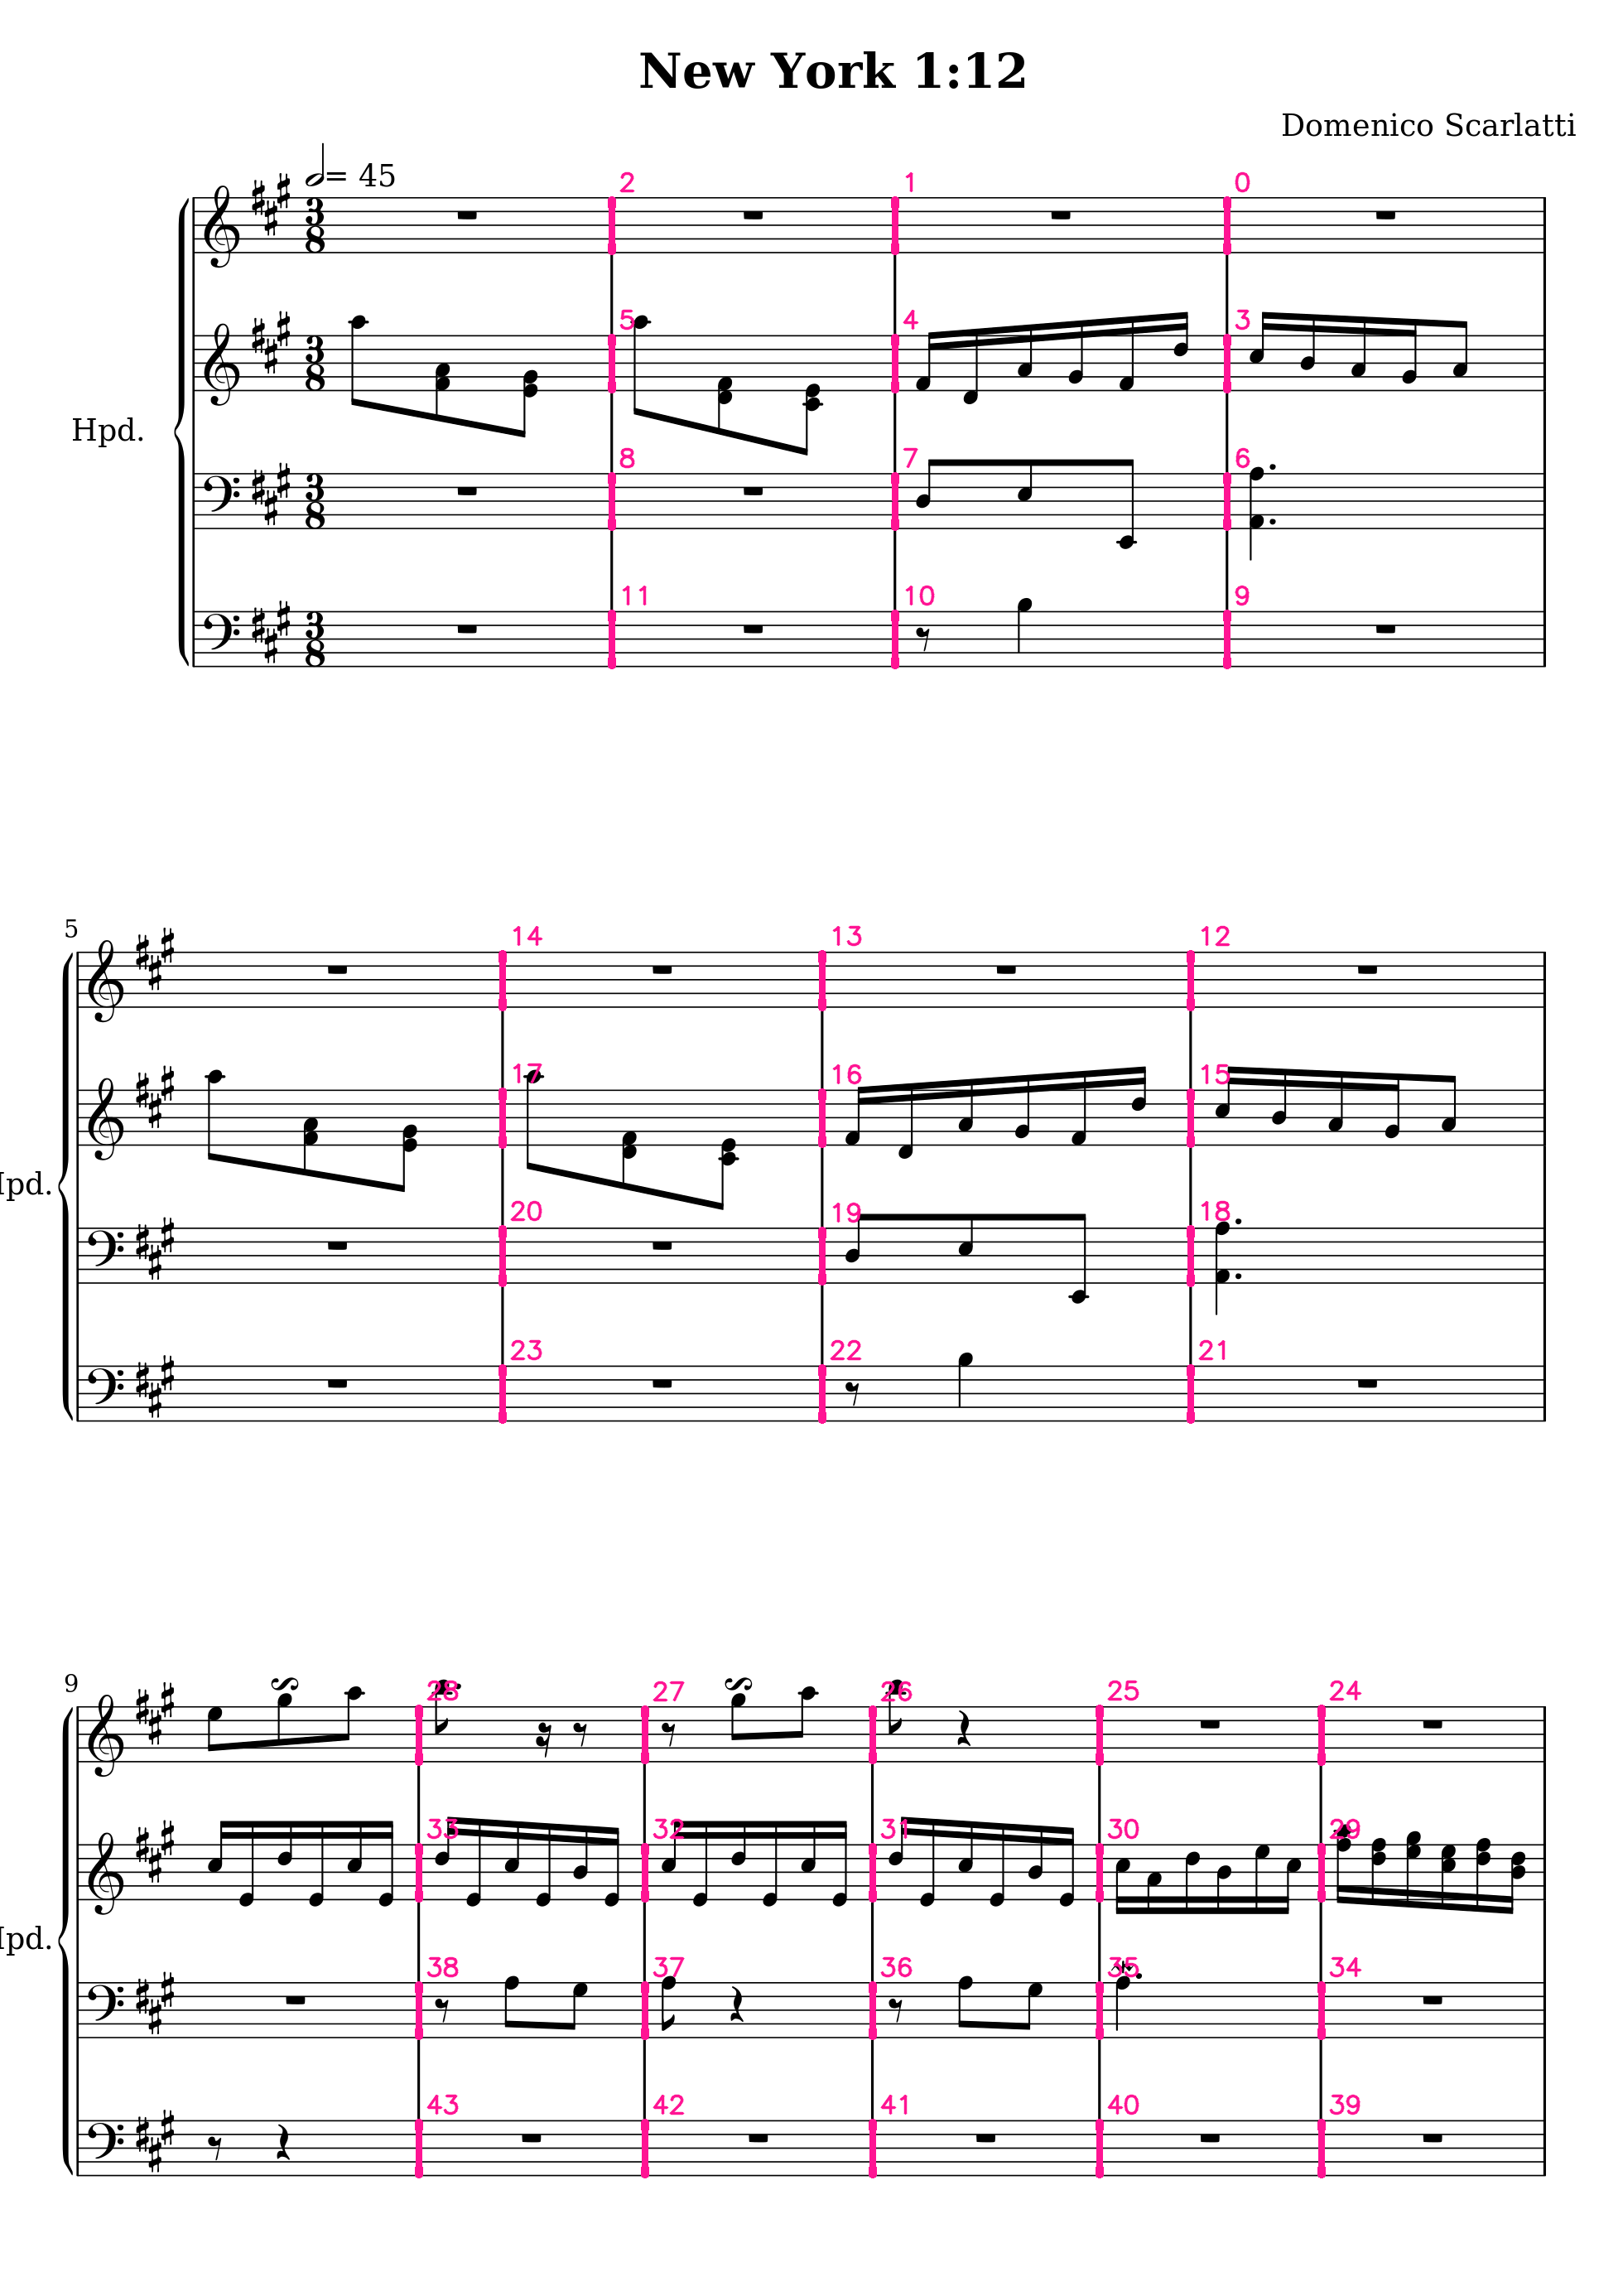

In [508]:
import cv2
import numpy as np
import pandas as pd
from IPython.display import Image

def draw_rectangles(image_path, data):
    image = cv2.imread(image_path)

    if image is None:
        raise ValueError("Image not found or path is incorrect")

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1  # Larger text
    font_color = (147, 20, 255)  # Pink
    font_thickness = 2  # Thicker text

    for index, row in data.iterrows():
        points = np.array(row['o_bbox'], dtype=np.int32).reshape((-1, 1, 2))
        # Draw the polygon
        cv2.polylines(image, [points], isClosed=True, color=(147, 20, 255), thickness=5)
        
        # Calculate the position for text (putting it at the center of the polygon)
        M = cv2.moments(points)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            # If the contour is too small or has some issues, we'll just use the first point
            cX, cY = points[0][0]

        # Offset the text position above and to the right of the center of the polygon
        text_offset_x = 10  # Horizontal offset
        text_offset_y = -10  # Vertical offset

        # Draw the index number
        cv2.putText(image, str(index), (cX + text_offset_x, cY + text_offset_y), 
                    font, font_scale, font_color, font_thickness, lineType=cv2.LINE_AA)

    return image


result_image = draw_rectangles(f'''./ds2_dense/images/{image_path}''', test_df)

# After you have your result_image
cv2.imwrite('./result_image.png', result_image)  # Save the image to a file

# Use IPython display to show the image in the notebook
display(Image(filename='./result_image.png'))

In [509]:
grouped_bbox_df

,filename,0,measure_bbox,new_measure_bbox,new_measure_bbox_updated
0,lg-101766503886095953-aug-beethoven--page-1.png,"{'measure_0_1': [[1387.0, 377.0, 1390.0, 377.0...","{'measure_0_1': [910.0, 377.0, 1390.0, 377.0, ...","{'measure_0_1': [910.0, 377.0, 1390.0, 377.0, ...","{'measure_0_1': [910.0, 377.0, 1390.0, 377.0, ..."
1,lg-101766503886095953-aug-beethoven--page-4.png,"{'measure_0_1': [[1456.0, 128.0, 1459.0, 128.0...","{'measure_0_1': [1045.0, 128.0, 1459.0, 128.0,...","{'measure_0_1': [1045.0, 128.0, 1459.0, 128.0,...","{'measure_0_1': [1045.0, 128.0, 1459.0, 128.0,..."
2,lg-101766503886095953-aug-gonville--page-1.png,"{'measure_0_1': [[1381.0, 377.0, 1384.0, 377.0...","{'measure_0_1': [897.0, 377.0, 1384.0, 377.0, ...","{'measure_0_1': [897.0, 377.0, 1384.0, 377.0, ...","{'measure_0_1': [897.0, 377.0, 1384.0, 377.0, ..."
3,lg-101766503886095953-aug-gonville--page-4.png,"{'measure_0_1': [[1453.0, 128.0, 1457.0, 128.0...","{'measure_0_1': [1041.0, 128.0, 1457.0, 128.0,...","{'measure_0_1': [1041.0, 128.0, 1457.0, 128.0,...","{'measure_0_1': [1041.0, 128.0, 1457.0, 128.0,..."
4,lg-102414375-aug-beethoven--page-2.png,"{'measure_0_1': [[1435.0, 128.0, 1438.0, 128.0...","{'measure_0_1': [1035.0, 128.0, 1438.0, 128.0,...","{'measure_0_1': [1035.0, 128.0, 1438.0, 128.0,...","{'measure_0_1': [1035.0, 128.0, 1438.0, 128.0,..."
...,...,...,...,...,...
1289,lg-99362940543272795-aug-gonville-.png,"{'measure_0_1': [[1635.0, 213.0, 1639.0, 213.0...","{'measure_0_1': [1382.0, 213.0, 1639.0, 213.0,...","{'measure_0_1': [1382.0, 213.0, 1639.0, 213.0,...","{'measure_0_1': [1382.0, 213.0, 1639.0, 213.0,..."
1290,lg-99362940543272795-aug-gutenberg1939-.png,"{'measure_0_1': [[1639.0, 192.0, 1643.0, 192.0...","{'measure_0_1': [1380.0, 192.0, 1643.0, 192.0,...","{'measure_0_1': [1380.0, 192.0, 1643.0, 192.0,...","{'measure_0_1': [1380.0, 192.0, 1643.0, 192.0,..."
1291,lg-99362940543272795-aug-lilyjazz-.png,"{'measure_0_1': [[1637.0, 306.0, 1640.0, 306.0...","{'measure_0_1': [1385.0, 306.0, 1640.0, 306.0,...","{'measure_0_1': [1385.0, 306.0, 1640.0, 306.0,...","{'measure_0_1': [1385.0, 306.0, 1640.0, 306.0,..."
1292,lg-99722188-aug-emmentaler--page-1.png,"{'measure_0_1': [[1478.0, 391.0, 1481.0, 391.0...","{'measure_0_1': [977.0, 391.0, 1481.0, 391.0, ...","{'measure_0_1': [977.0, 391.0, 1481.0, 391.0, ...","{'measure_0_1': [977.0, 391.0, 1481.0, 391.0, ..."


In [510]:
test_df = grouped_bbox_df[grouped_bbox_df["filename"]==image_path]['new_measure_bbox_updated'].values[0]

test_df

{'measure_0_1': [1079.0, 240.0, 1483.0, 240.0, 1483.0, 804.0, 1079.0, 804.0],
 'measure_1_2': [737.0, 240.0, 1082.0, 240.0, 1082.0, 804.0, 737.0, 804.0],
 'measure_3_4': [991.0, 1150.0, 1439.0, 1150.0, 1439.0, 1715.0, 991.0, 1715.0],
 'measure_4_5': [605.0, 1150.0, 994.0, 1150.0, 994.0, 1715.0, 605.0, 1715.0],
 'measure_6_7': [1326.0,
  2061.0,
  1597.0,
  2061.0,
  1597.0,
  2626.0,
  1326.0,
  2626.0],
 'measure_7_8': [1052.0,
  2061.0,
  1329.0,
  2061.0,
  1329.0,
  2626.0,
  1052.0,
  2626.0],
 'measure_8_9': [777.0, 2062.0, 1055.0, 2062.0, 1055.0, 2626.0, 777.0, 2626.0],
 'measure_9_10': [504.0, 2061.0, 780.0, 2061.0, 780.0, 2626.0, 504.0, 2626.0],
 'initial_measure_0': [0, 240.0, 737.0, 240.0, 737.0, 804.0, 0, 804.0],
 'initial_measure_1': [0, 1150.0, 605.0, 1150.0, 605.0, 1715.0, 0, 1715.0],
 'initial_measure_2': [0, 2061.0, 504.0, 2061.0, 504.0, 2626.0, 0, 2626.0],
 'final_measure_0': [1960, 240.0, 1483.0, 240.0, 1483.0, 804.0, 1960, 804.0],
 'final_measure_1': [1960,
  1150.0

initial_measure_0 [0, 240.0, 737.0, 240.0, 737.0, 804.0, 0, 804.0]
initial_measure_1 [0, 1150.0, 605.0, 1150.0, 605.0, 1715.0, 0, 1715.0]
initial_measure_2 [0, 2061.0, 504.0, 2061.0, 504.0, 2626.0, 0, 2626.0]


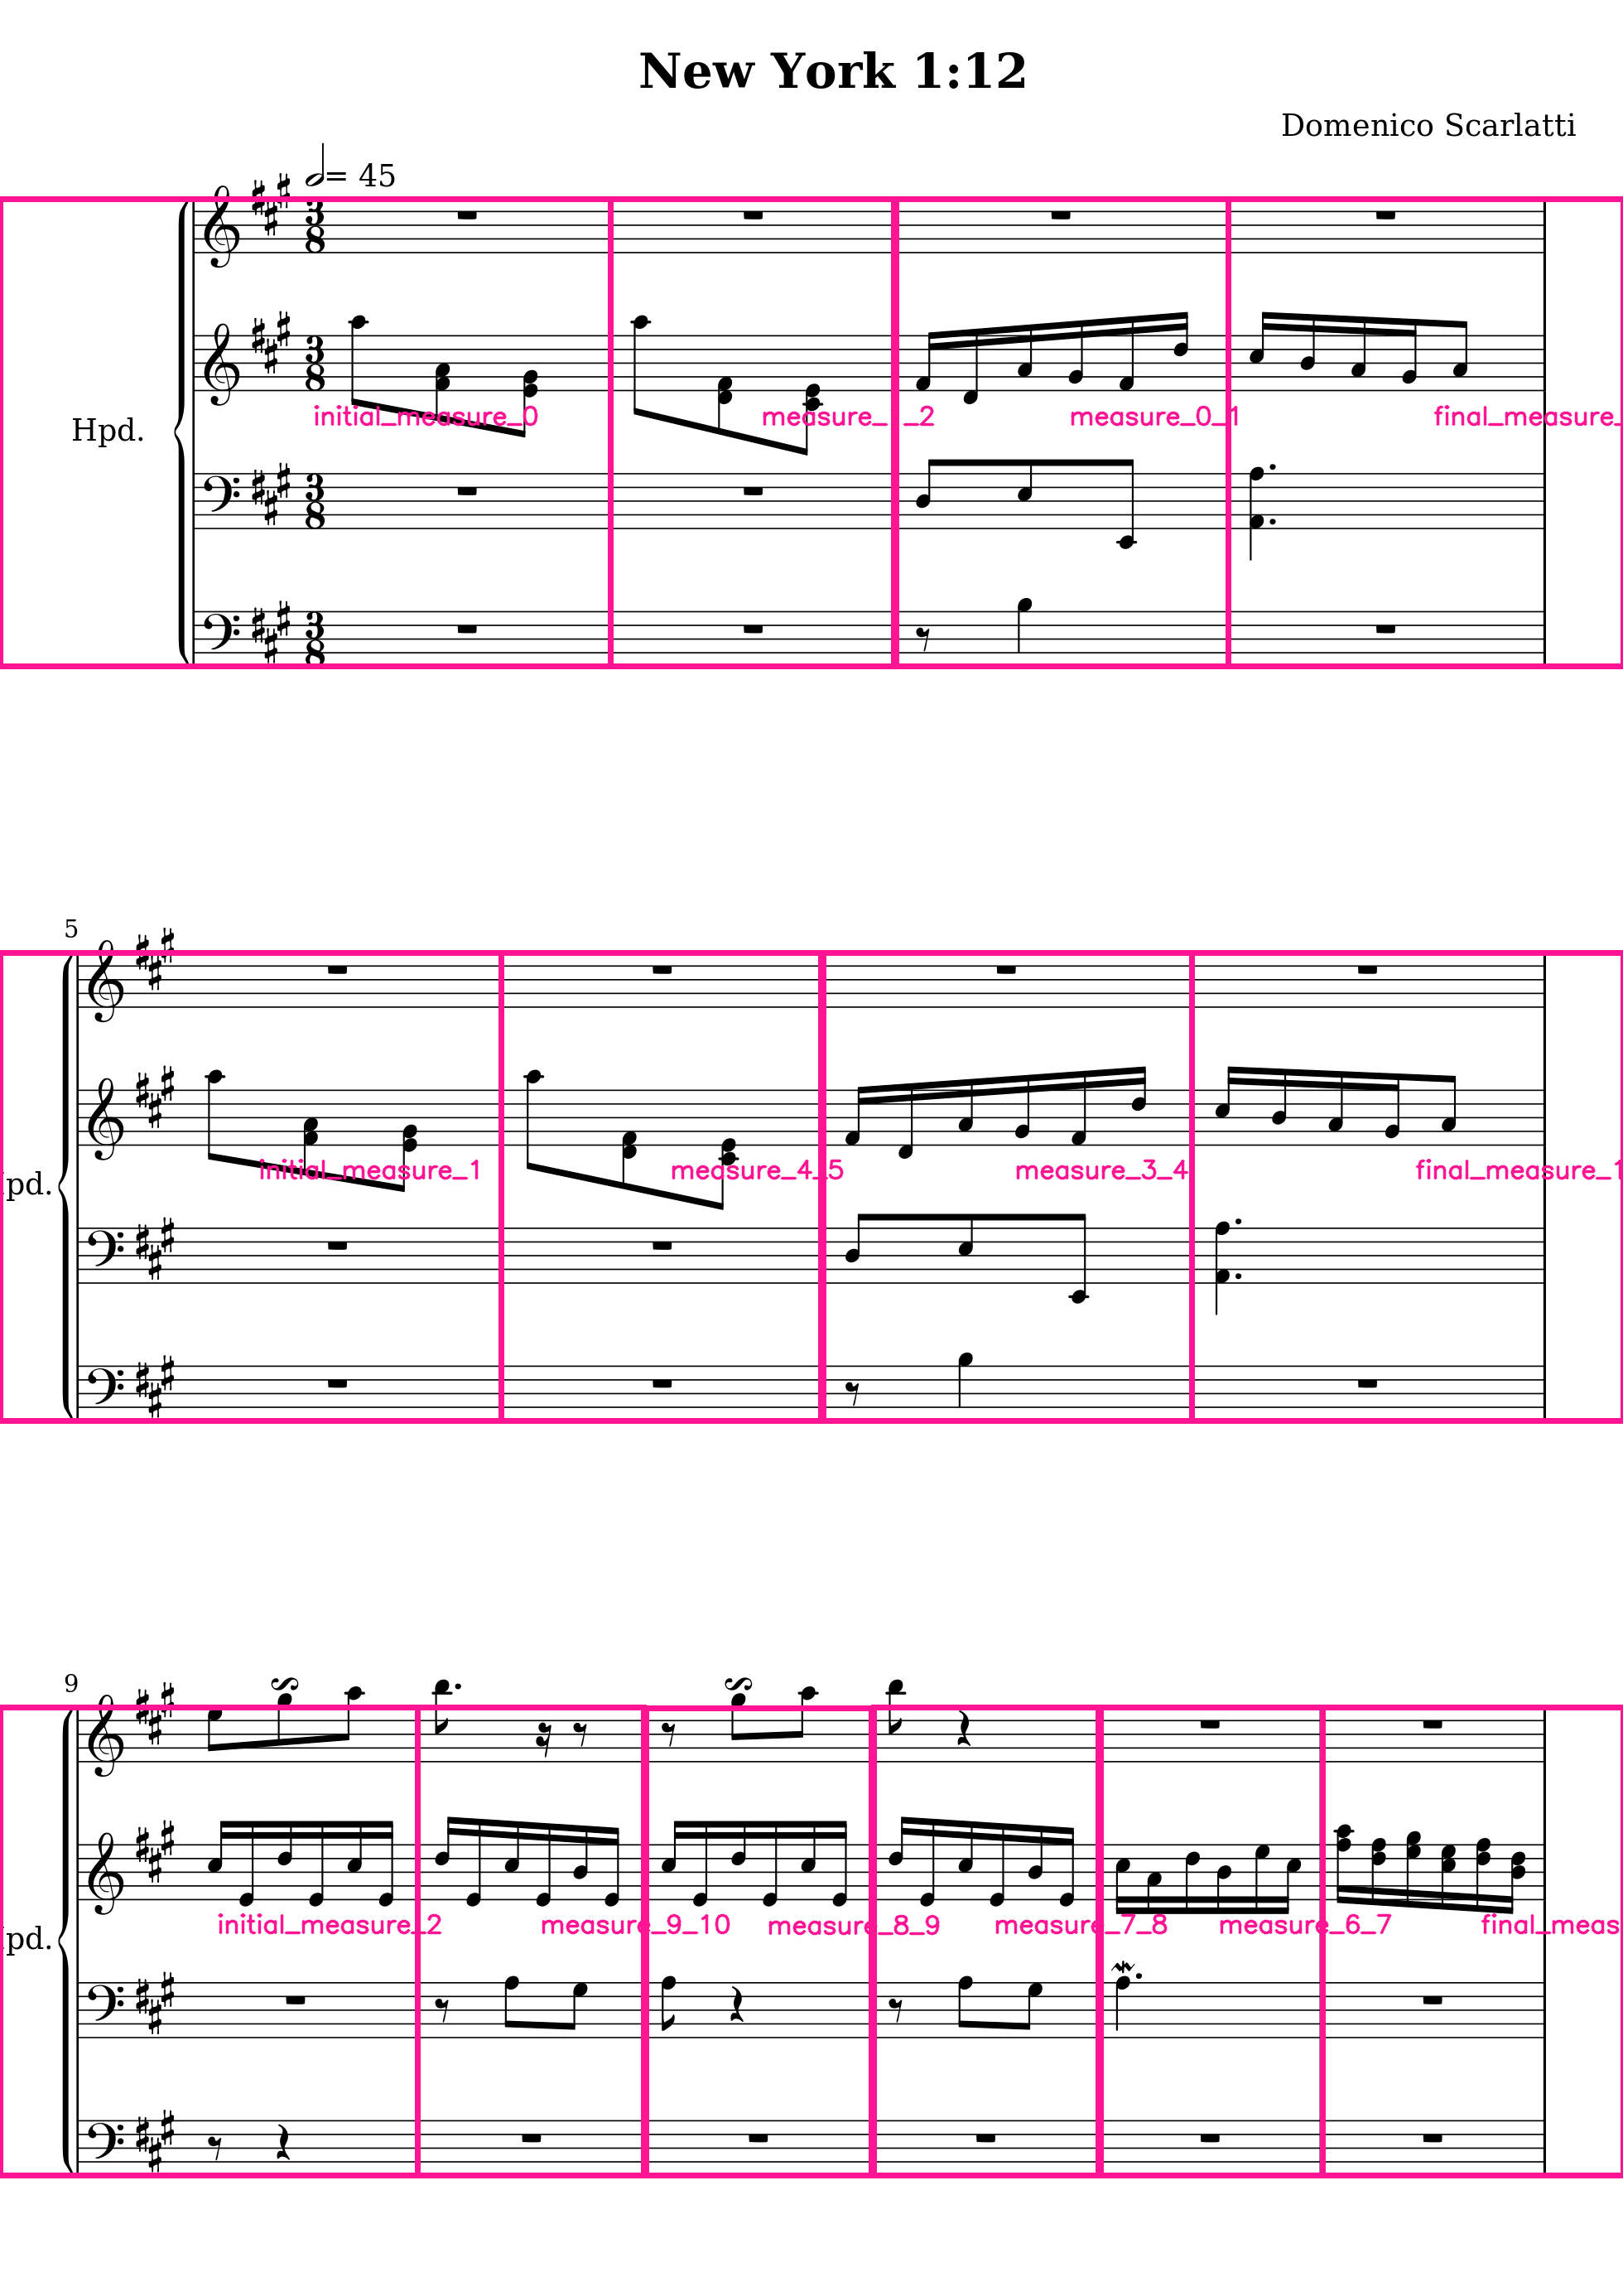

In [511]:
import cv2
import numpy as np
import pandas as pd
from IPython.display import Image


def draw_rectangles(image_path, data):
    image = cv2.imread(image_path)

    if image is None:
        raise ValueError("Image not found or path is incorrect")

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1  # Larger text
    font_color = (147, 20, 255)  # Pink
    font_thickness = 2  # Thicker text

    for key, coordinates in data.items():
        points = np.array(coordinates, dtype=np.int32).reshape((-1, 1, 2))
        # Draw the polygon
        cv2.polylines(image, [points], isClosed=True, color=(147, 20, 255), thickness=5)
        
        if key.startswith('initial_measure'):
            print(key, coordinates)
        # Calculate the position for text (putting it at the center of the box)
        M = cv2.moments(points)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            # If the contour is too small or has some issues, we'll just use the first point
            cX, cY = points[0][0]

        # Offset the text position above and to the right of the center of the box
        text_offset_x = 10  # Horizontal offset
        text_offset_y = -10  # Vertical offset

        # Draw the index number
        cv2.putText(image, str(key), (cX + text_offset_x, cY + text_offset_y), 
                    font, font_scale, font_color, font_thickness, lineType=cv2.LINE_AA)

    return image

# Filtering
test_df = grouped_bbox_df[grouped_bbox_df["filename"]==image_path]['new_measure_bbox_updated'].values[0]

result_image = draw_rectangles(f'''./ds2_dense/images/{image_path}''', test_df)

# After you have your result_image
cv2.imwrite('./result_image.png', result_image)  # Save the image to a file

# Use IPython display to show the image in the notebook
display(Image(filename='./result_image.png'))